In [1]:
import matplotlib.pyplot as plt
import numpy as np

import lsst.daf.butler as dB
import lsst.cp.verify.notebooks.utils as utils
import lsst.afw.display as afwDisplay

In [2]:
# This cell should be edited to match the data to be inspected.

# Which calibration type to analyse.
calibType = 'flat'
physical_filter = 'empty~empty'
# Camera
cameraName = 'LATISS'

# Set which display to use.
afwDisplay.setDefaultBackend("astrowidgets")

# Collection name containing the verification outputs.
verifyCollection = 'u/czw/DM-28920/verifyFlat.20210720Xb'
# Collection that the calibration was constructed in.
genCollection = 'u/czw/DM-28920/flatGen.20210720Xb'

/home/czw/.local/lib/python3.8/site-packages/ginga/cmap.py:13317: MatplotlibDeprecationWarning: The global colormaps dictionary is no longer considered public API.
  for name in _cm.cmap_d:


In [3]:
# Get butler and camera
butler = dB.Butler("/repo/main/", collections=[verifyCollection, genCollection])
camera = butler.get('camera', instrument=cameraName)

In [4]:
# Get Run Statistics
runStats = butler.get('verifyFlatStats', instrument=cameraName)
runSuccess = runStats.pop('SUCCESS')

In [5]:
display = afwDisplay.Display(dims=(1000, 1000))
display.embed()

ImageWidget(children=(Image(value=b'', format='jpeg', height='1000', layout="Layout(margin='0')", width='1000'…

In [6]:
# View calibration images:
continueDisplay = True
for detector in camera:
    detectorId = detector.getId()
    calib = butler.get(calibType, instrument=cameraName, physical_filter=physical_filter, detector=detectorId)
    calibArray = calib.getImage().getArray()

    # Get simple stats
    q25, q50, q75 = np.percentile(calibArray.flatten(), [25, 50, 75])
    sigma = 0.74 * (q75 - q25)
    print(f"Detector: {detector.getName()} Median: {q50}   Stdev: {sigma}")

    display.mtv(calib)
    display._scale('linear', (q50 - 3.0 * sigma), (q50 + 3.0* sigma), "")

    continueDisplay, skipNumber = utils.interactiveBlock(f"{calibType} {detector.getName()}", {})
    if continueDisplay is False:
        break

Detector: RXX_S00 Median: 0.9987115859985352   Stdev: 0.011343903541564941
flat RXX_S00 Continue? [h, c, q, p, #]q


In [7]:
# Display summary table of tests and failure counts.
utils.failureTable(runStats)

2021011900083,ALL PASS
2021011900088,ALL PASS
2021011900091,ALL PASS
2021011900092,ALL PASS
2021011900093,ALL PASS
2021011900094,ALL PASS
2021011900095,ALL PASS
2021011900096,ALL PASS
2021011900097,ALL PASS
2021011900098,ALL PASS
2021011900099,ALL PASS


In [8]:
# This block allows the residual images to be scanned for concerns.
blinkResiduals = True
if blinkResiduals:
    continueDisplay = True
    skipNumber = 0
    for exposureId, stats in runStats.items():
        for detector in camera:
            if skipNumber > 0:
                skipNumber -= 1
                continue
        
            detId = detector.getId()
            residual = butler.get('verifyFlatProc', instrument=cameraName, exposure=exposureId, detector=0)
            detStats = butler.get('verifyFlatDetStats', instrument=cameraName, exposure=exposureId, detector=0)
            display.mtv(residual)
            display.scale('linear', 'zscale', None)
        
            continueDisplay, skipNumber = utils.interactiveBlock(f"{exposureId} {detector.getName()}", detStats)
            if continueDisplay is False:
                break
        if continueDisplay is False:
            break

2021011900083 RXX_S00 Continue? [h, c, q, p, #]
2021011900088 RXX_S00 Continue? [h, c, q, p, #]
2021011900091 RXX_S00 Continue? [h, c, q, p, #]
2021011900092 RXX_S00 Continue? [h, c, q, p, #]q


In [9]:
utils.plotFailures(runStats, camera, scaleFactor=8)

No failures found.


In [ ]:
# Additional cells follow here.

In [11]:
# Get data for mean(expTime) plot.
ampMeans = {}
for detector in camera:
    ampMeans[detector.getName()] = {}
    for amp in detector.getAmplifiers():
        ampMeans[detector.getName()][amp.getName()] = {'ID': [], 'EXPTIME': [], 'MEAN': []}

for exposureId, stats in runStats.items():
    expTime = next(butler.registry.queryDimensionRecords('exposure', 
                                                         instrument=cameraName,
                                                         exposure=exposureId)).exposure_time
    for detector in camera:
        detId = detector.getId()
        detStats = butler.get('verifyFlatDetStats', instrument=cameraName, exposure=exposureId, detector=detId)
    
        for amp in detector.getAmplifiers():
            mean = detStats['AMP'][amp.getName()]['MEAN']
            ampMeans[detector.getName()][amp.getName()]['ID'].append(exposureId)
            ampMeans[detector.getName()][amp.getName()]['MEAN'].append(mean)
            ampMeans[detector.getName()][amp.getName()]['EXPTIME'].append(expTime)

<Figure size 576x576 with 0 Axes>

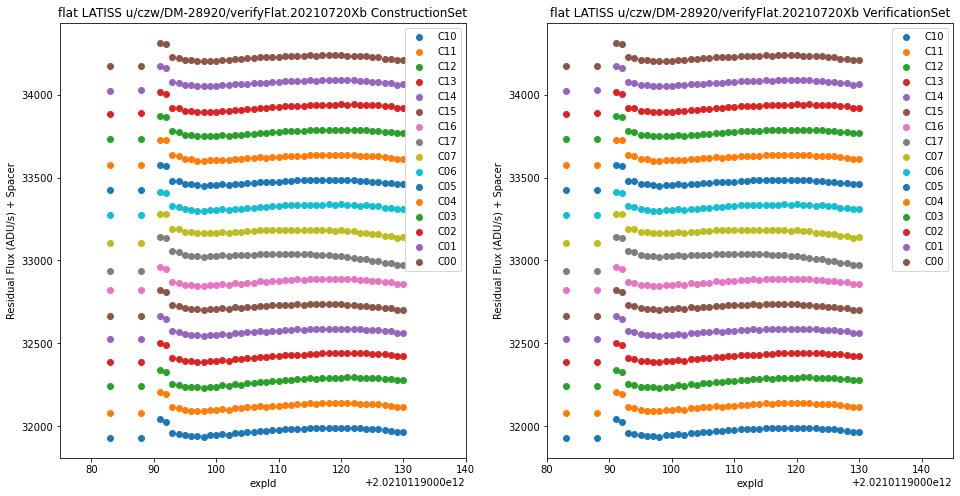

RXX_S00 Continue? [h, c, q, p, #]


In [16]:
# Plot flux as a function of exposure id, to look for time trends.
continueDisplay = True
for detector in camera:
    detName = detector.getName()

    horizontalSpace = 0.0
    verticalSpace = 150
    plt.figure(figsize=(8, 8))
    fig, axes = plt.subplots(1, 2, figsize=(2 * 8, 8))
    for axis, chunk in zip(axes, [0, 1]):
        for spacer, amp in enumerate(detector.getAmplifiers()):
            axis.scatter(np.array(ampMeans[detName][amp.getName()]['ID']) + horizontalSpace * spacer,
                         np.array(ampMeans[detName][amp.getName()]['MEAN']) /
                         np.array(ampMeans[detName][amp.getName()]['EXPTIME']) + verticalSpace * spacer,
                        label=amp.getName())
        axis.set_xlabel("expId")
        axis.set_ylabel("Residual Flux (ADU/s) + Spacer")

        
        if chunk == 0:
            axis.set_xlim(2021011900075, 2021011900140)
            axis.set_title(f"{calibType} {cameraName} {verifyCollection} ConstructionSet")
        else:
            axis.set_xlim(2021011900080, 2021011900145)
            axis.set_title(f"{calibType} {cameraName} {verifyCollection} VerificationSet")
        axis.legend()
    plt.show()
    continueDisplay, skipNumber = utils.interactiveBlock(detName, {})
    if continueDisplay is False:
        break

<Figure size 576x576 with 0 Axes>

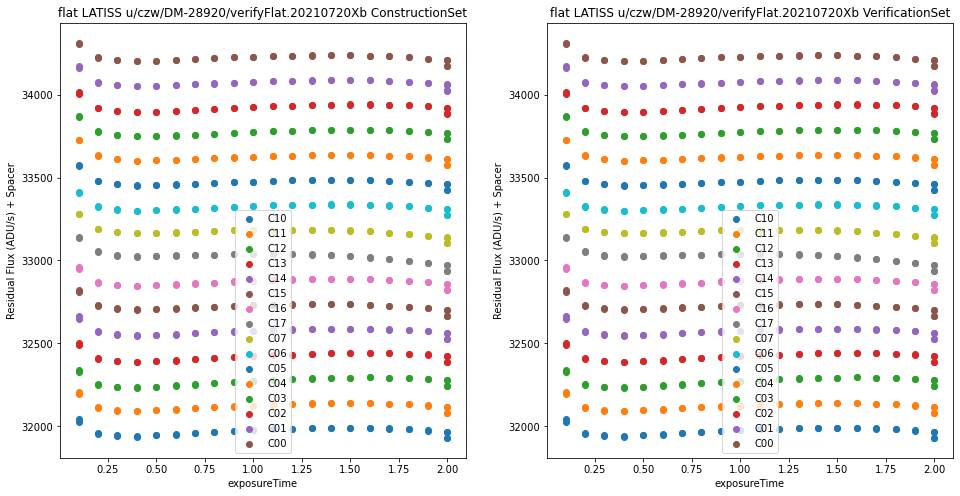

RXX_S00 Continue? [h, c, q, p, #]


In [18]:
# Plot flux as a function of exposure time, to confirm the residual is flat.
continueDisplay = True
for detector in camera:
    detName = detector.getName()

    horizontalSpace = 0.0
    verticalSpace = 150
    plt.figure(figsize=(8, 8))
    fig, axes = plt.subplots(1, 2, figsize=(2 * 8, 8))
    for axis, chunk in zip(axes, [0, 1]):
        for spacer, amp in enumerate(detector.getAmplifiers()):
            axis.scatter(np.array(ampMeans[detName][amp.getName()]['EXPTIME']) + horizontalSpace * spacer,
                         np.array(ampMeans[detName][amp.getName()]['MEAN']) /
                         np.array(ampMeans[detName][amp.getName()]['EXPTIME']) + verticalSpace * spacer,
                        label=amp.getName())
        axis.set_xlabel("exposureTime")
        axis.set_ylabel("Residual Flux (ADU/s) + Spacer")

        
        if chunk == 0:
            axis.set_title(f"{calibType} {cameraName} {verifyCollection} ConstructionSet")
        else:
            axis.set_title(f"{calibType} {cameraName} {verifyCollection} VerificationSet")
        axis.legend()
    plt.show()
    continueDisplay, skipNumber = utils.interactiveBlock(detName, {})
    if continueDisplay is False:
        break